In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/roger/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/roger/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv", header=0)

# Removing auto measures
auto_measures = [c for c in hoyle_data.columns if c[:2] == "c_"] + ["u_mass_full"]
hoyle_data = hoyle_data.drop(columns = auto_measures)
hoyle_data.head(5).T

# Subsetting by intrusion task
d = hoyle_data[hoyle_data["task"]=="intrusions"].drop(columns="task")

# Adding index to join samples on
d.loc[:, "s_dim_0"] = range(len(d))

In [16]:
hoyle_data.loc[hoyle_data.index==0, "scores_raw"] = 5

In [17]:
hoyle_data

,dataset,model,topic_idx,human_idx,scores_raw,confidences_raw,task
0,wikitext,mallet,0,0,5,1,ratings
1,wikitext,mallet,0,1,3,1,ratings
2,wikitext,mallet,0,2,1,1,ratings
3,wikitext,mallet,0,3,3,1,ratings
4,wikitext,mallet,0,4,3,1,ratings
...,...,...,...,...,...,...,...
12295,nytimes,etm,49,21,0,1,intrusions
12296,nytimes,etm,49,22,1,1,intrusions
12297,nytimes,etm,49,23,0,1,intrusions
12298,nytimes,etm,49,24,1,1,intrusions


In [3]:
## Creating unique identifier for each topic

unique_topic_ids = (d.groupby(["dataset", "model", "topic_idx"], as_index=False)
    .agg({"scores_raw":"count"})
    .drop(columns="scores_raw"))
unique_topic_ids["m_topic"] = unique_topic_ids.index
d1 = pd.merge(d, unique_topic_ids, on=["dataset", "model", "topic_idx"], how="left")

In [4]:
# Setting up numpy arrays for pymc
topics = np.array(d1["m_topic"])
n_topics = d1["m_topic"].nunique()
scores = np.array(d1["scores_raw"])

In [5]:
centered_model = pm.Model()
with centered_model:
    # Hyperparameter priors
    mu_a = pm.Normal("mu_a", mu=0, sigma=1.5)
    sigma_a = pm.Exponential("sigma_a", lam=2) 
    
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_topics)
    p = pm.math.invlogit(a[topics])
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=scores)

    centered_trace=pm.sample(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [6]:
with centered_model:
    centered_prior=pm.sample_prior_predictive(1_000)
    centered_posterior = pm.sample_posterior_predictive(centered_trace)

In [7]:
non_centered_model = pm.Model()
with non_centered_model:
    # Hyperparameter priors
    mu_a = pm.Normal("mu_a", mu=0, sigma=1.5)
    z = pm.Normal("z", mu=0, sigma=1, shape=n_topics)
    sigma_a = pm.Exponential("sigma_a", lam=2) 
    
    a = pm.Deterministic("a", mu_a + z[topics]*sigma_a)
    p = pm.math.invlogit(a)
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=scores)

    non_centered_trace=pm.sample(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, z, sigma_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


In [8]:
with non_centered_model:
    non_centered_prior=pm.sample_prior_predictive(1_000)
    non_centered_posterior = pm.sample_posterior_predictive(non_centered_trace)

[]

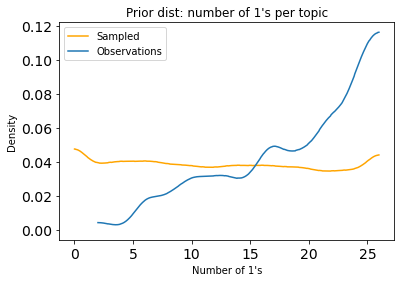

In [9]:
# Plotting distribution of scores simulated from prior
prior=centered_prior

samples_df = prior.prior_predictive.sel(chain=0)
target = "s"

# Manipulating samples to plot
df_prior = samples_df[target].to_dataframe()
pos_of_draw = list(df_prior.index.names).index("draw")
df_prior["draw"] = df_prior.index.get_level_values(pos_of_draw)

# Joining rater/topic/model/corpus information
df_prior1 = pd.merge(df_prior, d1, on=target+"_dim_0", how="left")

# Aggregating "1" counts by topic
sample_agg = df_prior1.groupby(["draw", "m_topic"]).agg({target:"sum"})
obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "m_topic"]).agg({"scores_raw":"sum"})

# Setting up plot
_, ax = plt.subplots(1, 1)
ax = az.plot_kde(np.array(sample_agg[target]), bw=1)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(obs_agg["scores_raw"]), bw=1)
ax.set_title("Prior dist: number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("Number of 1's")
ax.legend(ax.get_lines(), ["Sampled", "Observations"])
plt.plot()

[]

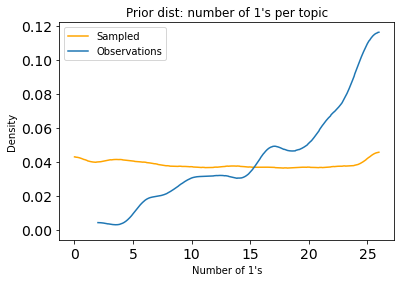

In [10]:
# Plotting distribution of scores simulated from prior
prior=non_centered_prior

samples_df = prior.prior_predictive.sel(chain=0)
target = "s"

# Manipulating samples to plot
df_prior = samples_df[target].to_dataframe()
pos_of_draw = list(df_prior.index.names).index("draw")
df_prior["draw"] = df_prior.index.get_level_values(pos_of_draw)

# Joining rater/topic/model/corpus information
df_prior1 = pd.merge(df_prior, d1, on=target+"_dim_0", how="left")

# Aggregating "1" counts by topic
sample_agg = df_prior1.groupby(["draw", "m_topic"]).agg({target:"sum"})
obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "m_topic"]).agg({"scores_raw":"sum"})

# Setting up plot
_, ax = plt.subplots(1, 1)
ax = az.plot_kde(np.array(sample_agg[target]), bw=1)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(obs_agg["scores_raw"]), bw=1)
ax.set_title("Prior dist: number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("Number of 1's")
ax.legend(ax.get_lines(), ["Sampled", "Observations"])
plt.plot()

[]

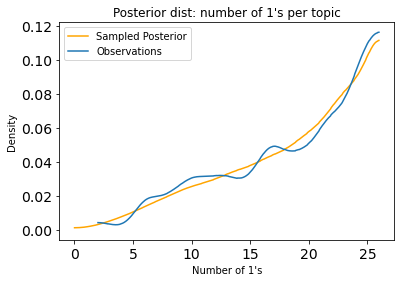

In [11]:
# Plotting distribution of scores simulated from posterior
posterior = centered_posterior
samples_df = posterior.posterior_predictive.sel(chain=0)
target = "s"

# Manipulating samples to plot
df_posterior = samples_df[target].to_dataframe()
pos_of_draw = list(df_posterior.index.names).index("draw")
df_posterior["draw"] = df_posterior.index.get_level_values(pos_of_draw)

# Joining rater/topic/model/corpus information
df_posterior1 = pd.merge(df_posterior, d1, on=target+"_dim_0", how="left")

# Aggregating "1" counts by topic
sample_agg = df_posterior1.groupby(["draw", "m_topic"]).agg({target:"sum"})
obs_agg = df_posterior1[df_posterior1["chain"]==0].groupby(["draw", "m_topic"]).agg({"scores_raw":"sum"})

# Setting up plot
_, ax = plt.subplots(1, 1)
ax = az.plot_kde(np.array(sample_agg[target]), bw=1)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(obs_agg["scores_raw"]), bw=1)
ax.set_title("Posterior dist: number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("Number of 1's")
ax.legend(ax.get_lines(), ["Sampled Posterior", "Observations"])
plt.plot()

[]

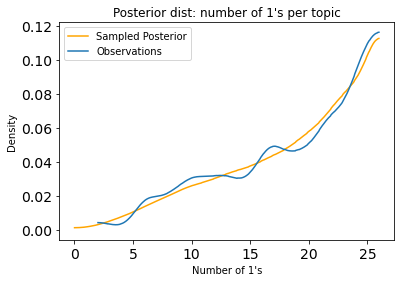

In [12]:
# Plotting distribution of scores simulated from posterior
posterior = non_centered_posterior
samples_df = posterior.posterior_predictive.sel(chain=0)
target = "s"

# Manipulating samples to plot
df_posterior = samples_df[target].to_dataframe()
pos_of_draw = list(df_posterior.index.names).index("draw")
df_posterior["draw"] = df_posterior.index.get_level_values(pos_of_draw)

# Joining rater/topic/model/corpus information
df_posterior1 = pd.merge(df_posterior, d1, on=target+"_dim_0", how="left")

# Aggregating "1" counts by topic
sample_agg = df_posterior1.groupby(["draw", "m_topic"]).agg({target:"sum"})
obs_agg = df_posterior1[df_posterior1["chain"]==0].groupby(["draw", "m_topic"]).agg({"scores_raw":"sum"})

# Setting up plot
_, ax = plt.subplots(1, 1)
ax = az.plot_kde(np.array(sample_agg[target]), bw=1)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(obs_agg["scores_raw"]), bw=1)
ax.set_title("Posterior dist: number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("Number of 1's")
ax.legend(ax.get_lines(), ["Sampled Posterior", "Observations"])
plt.plot()

In [16]:
centered_psis = az.loo(centered_trace)
centered_waic = az.waic(centered_trace)
print(centered_psis)
print(centered_waic)

# az.plot_khat(centered_psis.pareto_k) Plotting the posterior variance of the log predictive densities

Computed from 4000 posterior samples and 7800 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3881.36    45.75
p_loo      239.85        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     7800  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 4000 posterior samples and 7800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3880.03    45.72
p_waic      238.51        -

There has been a warning during the calculation. Please check the results.


/home/roger/anaconda3/envs/thesis/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [21]:
non_centered_psis = az.loo(non_centered_trace)
non_centered_waic = az.waic(non_centered_trace)
print(non_centered_psis)
print(non_centered_waic)

# az.plot_khat(non_centered_psis.pareto_k) Plotting the posterior variance of the log predictive densities

Computed from 4000 posterior samples and 7800 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3882.48    45.80
p_loo      241.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     7797  100.0%
 (0.5, 0.7]   (ok)          3    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 4000 posterior samples and 7800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3881.11    45.76
p_waic      239.84        -

There has been a warning during the calculation. Please check the results.


/home/roger/anaconda3/envs/thesis/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


===================================== Trace diagnostics =====================================
Divergent transitions
0    0
1    0
2    0
3    0
dtype: int64


Vars with highest rhat
            a
144  1.006488
156  1.005903
52   1.005269
227  1.005100
104  1.004991


5 variables with lowest effective sample size
               a
279  2935.545738
292  3157.397693
23   3262.758305
1    3395.935500
86   3404.941199


[]

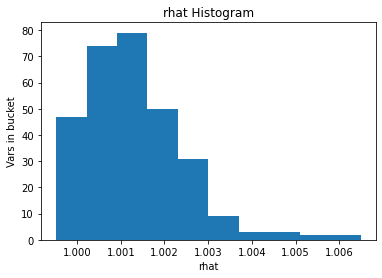

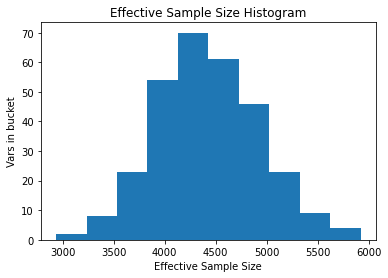

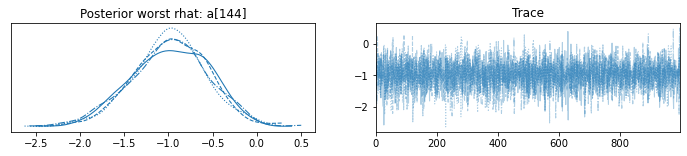

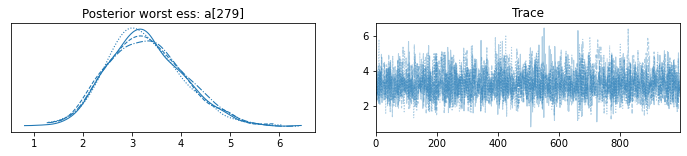

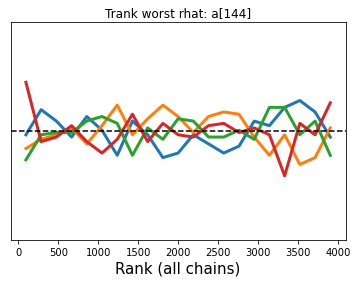

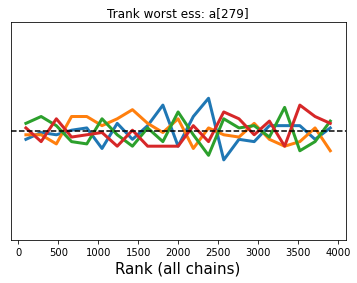

In [13]:
# MCMC Diagnostics
param = "a"
trace = centered_trace

rhat = pd.DataFrame(az.rhat(trace)[param], columns=[param]).sort_values(by=param, ascending=False)[:5]
worst_rhat = rhat.index[0]
ess = pd.DataFrame(az.ess(trace)[param], columns=[param]).sort_values(by=param)[:5]
worst_ess = ess.index[0]


print("===================================== Trace diagnostics =====================================")
print("Divergent transitions")
print(pd.DataFrame(trace.sample_stats["diverging"]).T.sum(axis="rows"))
print("\n")
print("Vars with highest rhat")
print(rhat)
print("\n")
print("5 variables with lowest effective sample size")
print(ess)

# Rhat Histogram
fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.hist(az.rhat(trace)[param])
ax1.set_title("rhat Histogram")
ax1.set_xlabel("rhat")
ax1.set_ylabel("Vars in bucket")

# ESS histogram
fig2 = plt.figure(2)
ax2 = fig2.add_subplot()
ax2.hist(az.ess(trace)[param])
ax2.set_title("Effective Sample Size Histogram")
ax2.set_xlabel("Effective Sample Size")
ax2.set_ylabel("Vars in bucket")

# Trace of worst rhat
ax3 = az.plot_trace(trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}))
ax3[0][0].set_title(f"Posterior worst rhat: {param}[{worst_rhat}]")
ax3[0][1].set_title("Trace")

# Trace of worst ess
ax4 = az.plot_trace(trace.posterior[param].sel(**{param+"_dim_0":worst_ess}))
ax4[0][0].set_title(f"Posterior worst ess: {param}[{worst_ess}]")
ax4[0][1].set_title("Trace")

# Trank of worst rhat
ax5 = az.plot_rank(trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax5.set_title(f"Trank worst rhat: {param}[{worst_rhat}]")

# Trank of worst ESS
ax6 = az.plot_rank(trace.posterior[param].sel(**{param+"_dim_0":worst_ess}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax6.set_title(f"Trank worst ess: {param}[{worst_ess}]")

plt.plot()

===================================== Trace diagnostics =====================================
Divergent transitions
0    0
1    0
2    0
3    0
dtype: int64


Vars with highest rhat
            z
27   1.006876
223  1.005292
265  1.004965
23   1.004801
124  1.004744


5 variables with lowest effective sample size
               z
278  3753.263080
122  3860.912728
17   3924.052741
81   3931.143464
60   4019.394257


[]

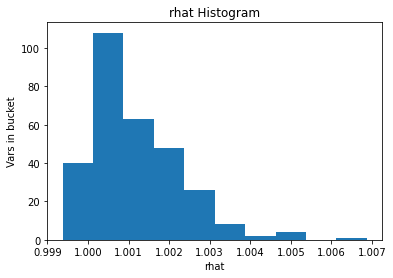

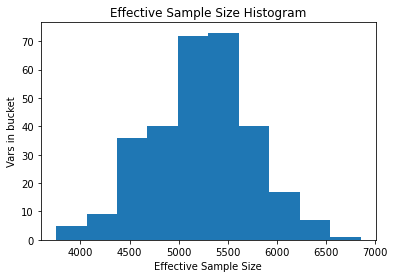

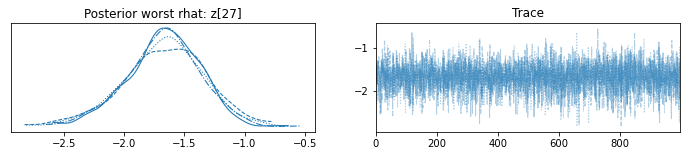

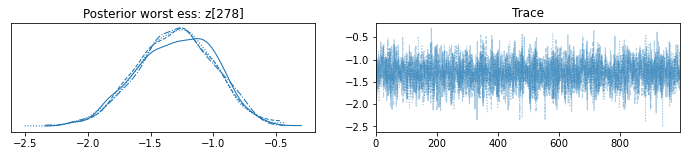

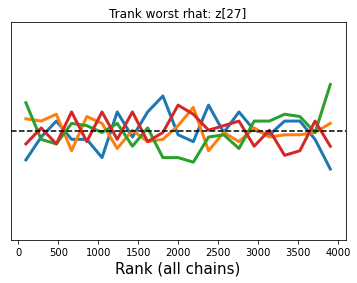

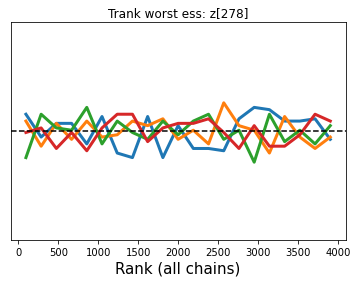

In [14]:
param = "z"
trace = non_centered_trace

rhat = pd.DataFrame(az.rhat(trace)[param], columns=[param]).sort_values(by=param, ascending=False)[:5]
worst_rhat = rhat.index[0]
ess = pd.DataFrame(az.ess(trace)[param], columns=[param]).sort_values(by=param)[:5]
worst_ess = ess.index[0]


print("===================================== Trace diagnostics =====================================")
print("Divergent transitions")
print(pd.DataFrame(trace.sample_stats["diverging"]).T.sum(axis="rows"))
print("\n")
print("Vars with highest rhat")
print(rhat)
print("\n")
print("5 variables with lowest effective sample size")
print(ess)

# Rhat Histogram
fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.hist(az.rhat(trace)[param])
ax1.set_title("rhat Histogram")
ax1.set_xlabel("rhat")
ax1.set_ylabel("Vars in bucket")

# ESS histogram
fig2 = plt.figure(2)
ax2 = fig2.add_subplot()
ax2.hist(az.ess(trace)[param])
ax2.set_title("Effective Sample Size Histogram")
ax2.set_xlabel("Effective Sample Size")
ax2.set_ylabel("Vars in bucket")

# Trace of worst rhat
ax3 = az.plot_trace(trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}))
ax3[0][0].set_title(f"Posterior worst rhat: {param}[{worst_rhat}]")
ax3[0][1].set_title("Trace")

# Trace of worst ess
ax4 = az.plot_trace(trace.posterior[param].sel(**{param+"_dim_0":worst_ess}))
ax4[0][0].set_title(f"Posterior worst ess: {param}[{worst_ess}]")
ax4[0][1].set_title("Trace")

# Trank of worst rhat
ax5 = az.plot_rank(trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax5.set_title(f"Trank worst rhat: {param}[{worst_rhat}]")

# Trank of worst ESS
ax6 = az.plot_rank(trace.posterior[param].sel(**{param+"_dim_0":worst_ess}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax6.set_title(f"Trank worst ess: {param}[{worst_ess}]")

plt.plot()